In [ ]:
from speechsep.imports import *
from speechsep.masks import *
from speechsep.pipe import *
from speechsep.models import *
from speechsep.data import *

# Trainer
> Mask Dataset Trainer with FastCore

In [ ]:
fn = Path('../data/esc50_sample/')

In [ ]:
class Trainer():
    def __init__(self, model, dataset, ds_tfms, mask_type=MaskcIRM):
        pipe = ds_tfms(dataset)
        store_attr(self, 'model, pipe, mask_type')
    def fit(self, epoch, loss_func, optimizer, lr=1e-4, mom=0.9, bs=4):
        pass
    def predict(self):
        pass

In [ ]:
trainer = Trainer(U_Net(), fn, AudioPipe)

# Testing

In [ ]:
model, pipe, mask_type = U_Net(), AudioPipe(fn), MaskcIRM

In [ ]:
epoch, loss_func, optimizer, lr, mom, bs = 2, F.cross_entropy, Adam, 1e-4, 0.9, 4

In [ ]:
out = pipe(0)

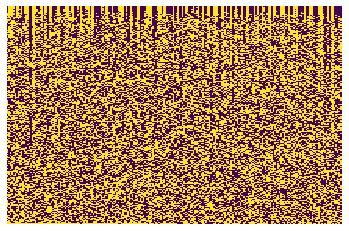

In [ ]:
out[0].show()

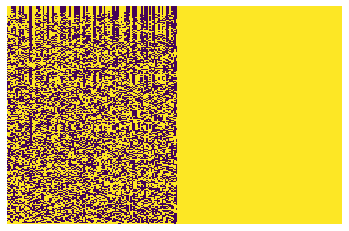

In [ ]:
out[1][0].show()

In [ ]:
data = [pipe(i) for i in range(len(get_audio_files(fn)))]
x_train, y_train = zip(*data)
n = len(x_train)

In [ ]:
def get_loss():
    pass

def pred2mask(pred):
    print(pred.shape)
    return MaskcIRM(pred[:2]), MaskcIRM(pred[2:])

def predict(model, xb):
    masks = mask_type(model(xb))
    return masks[0]*xb, masks[1]*xb

def fit(epoch, loss_func, optimizer, lr=1e-4, mom=0.9, bs=4):
    optim = optimizer(model.parameters(), lr=lr, mom=mom)
    for e in range(epoch):
        optim.zero_grad()
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i*bs
            #TODO find batch pattern
            xb, yb = x_train[start_i:end_i], y_train[start_i:end_i]
            pred = model(xb)
            mask1, mask2 = pred2mask(pred)
            #TODO masks times mixed
            #specs = mask1
            loss = get_loss(specs, yb, loss_func)
            
            loss.backward()
        optim.step()

In [ ]:
fit(epoch=epoch, loss_func=loss_func, optimizer=optimizer)